In [47]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
from scipy.linalg import hankel

params = {}
params['embedding_dimension'] = 10
params['partial_measurement'] =7
params['latent_dim'] = 10

In [48]:
with open('Results/final_output.pkl', 'rb') as f:
    results = pickle.load(f)

X_ori = results['x'].cpu().detach().numpy()
dx_ori = results['dx'].cpu().detach().numpy()
z = results['z'].cpu().detach().numpy()
sindy_coeff = results['sindy_coefficients'].cpu().detach().numpy()
Theta = results['Theta'].cpu().detach().numpy()

measured_index = [i*params['embedding_dimension'] for i in range(params['partial_measurement'])]
X_ori = X_ori[:, measured_index]
dx_ori = dx_ori[:, measured_index]

In [49]:
train_loss = np.load("Results/train_loss.npy")
val_loss = np.load("Results/val_loss.npy")
refine_loss = np.load("Results/refine_loss.npy")
refine_val_loss = np.load("Results/refine_val_loss.npy")

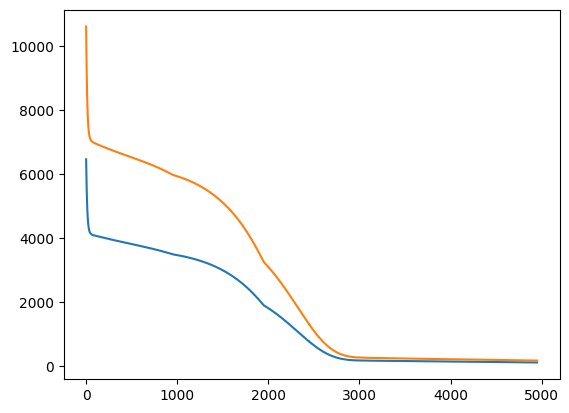

In [50]:
plt.plot(train_loss[50:])
plt.plot(val_loss[50:])

In [51]:
# plt.plot(refine_loss)
# plt.plot(refine_val_loss)

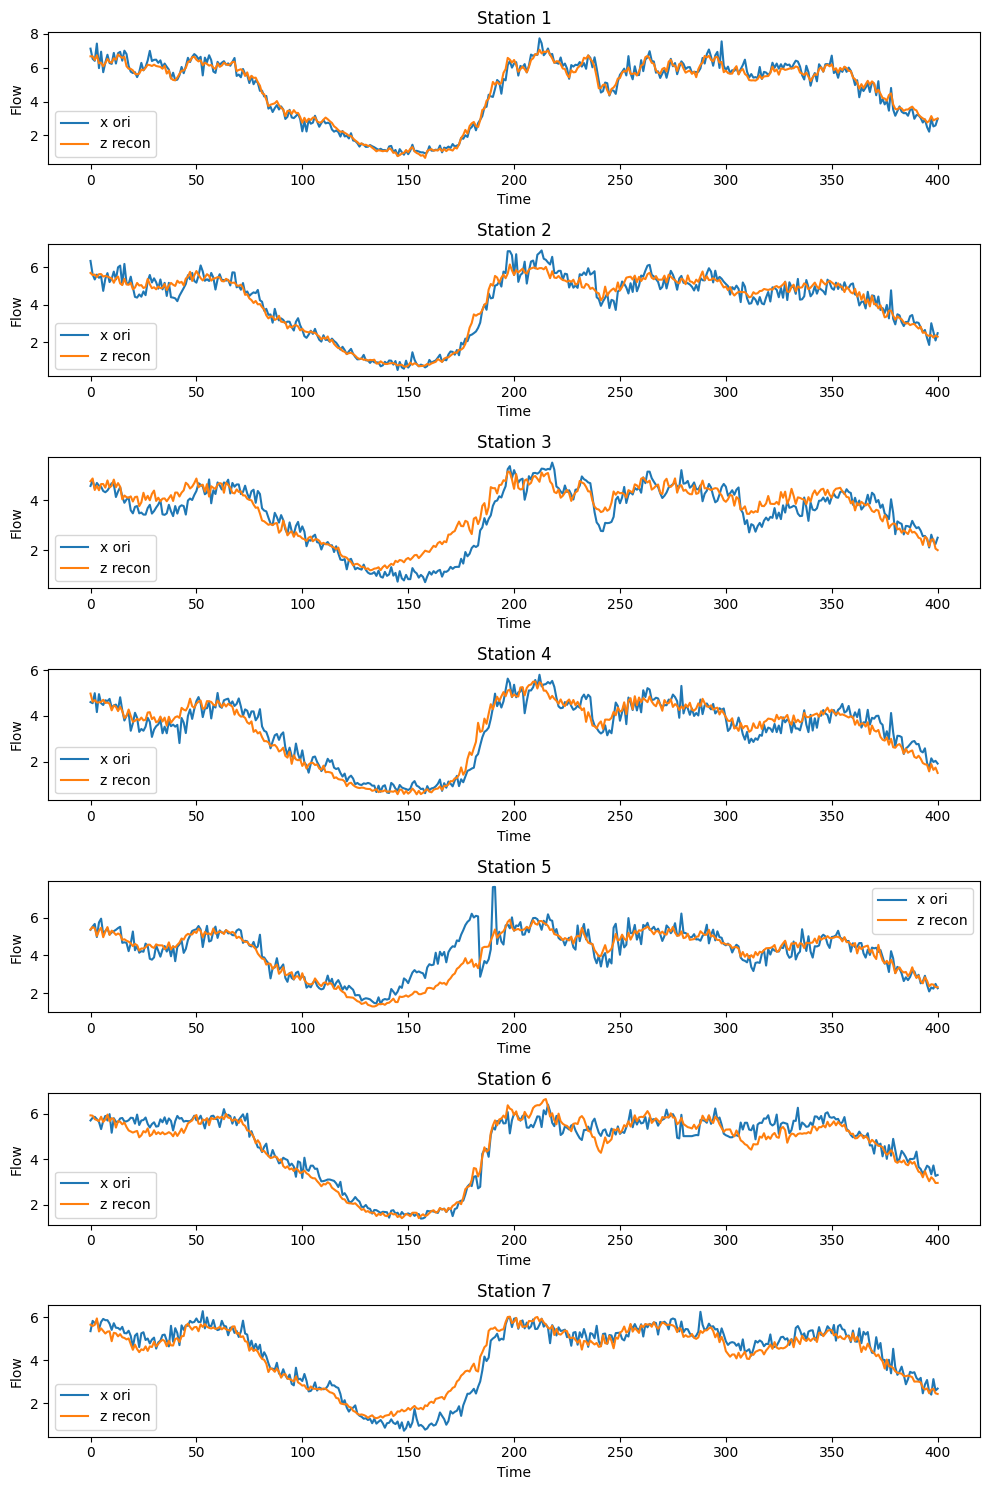

In [52]:
# Create a figure with 5 subplots (one for each column)
fig, axs = plt.subplots(nrows=X_ori.shape[1], ncols=1, figsize=(10, 15))

# Plot each column in a separate subplot
for i in range(X_ori.shape[1]):
    axs[i].plot(X_ori[:, i], label = 'x ori')
    axs[i].plot(z[:,i], label = 'z recon')
    axs[i].legend()

# Add titles and axis labels to the subplots
for i, ax in enumerate(axs):
    ax.set_title(f'Station {i+1}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Flow')

# Show the figure
plt.tight_layout()
plt.show()

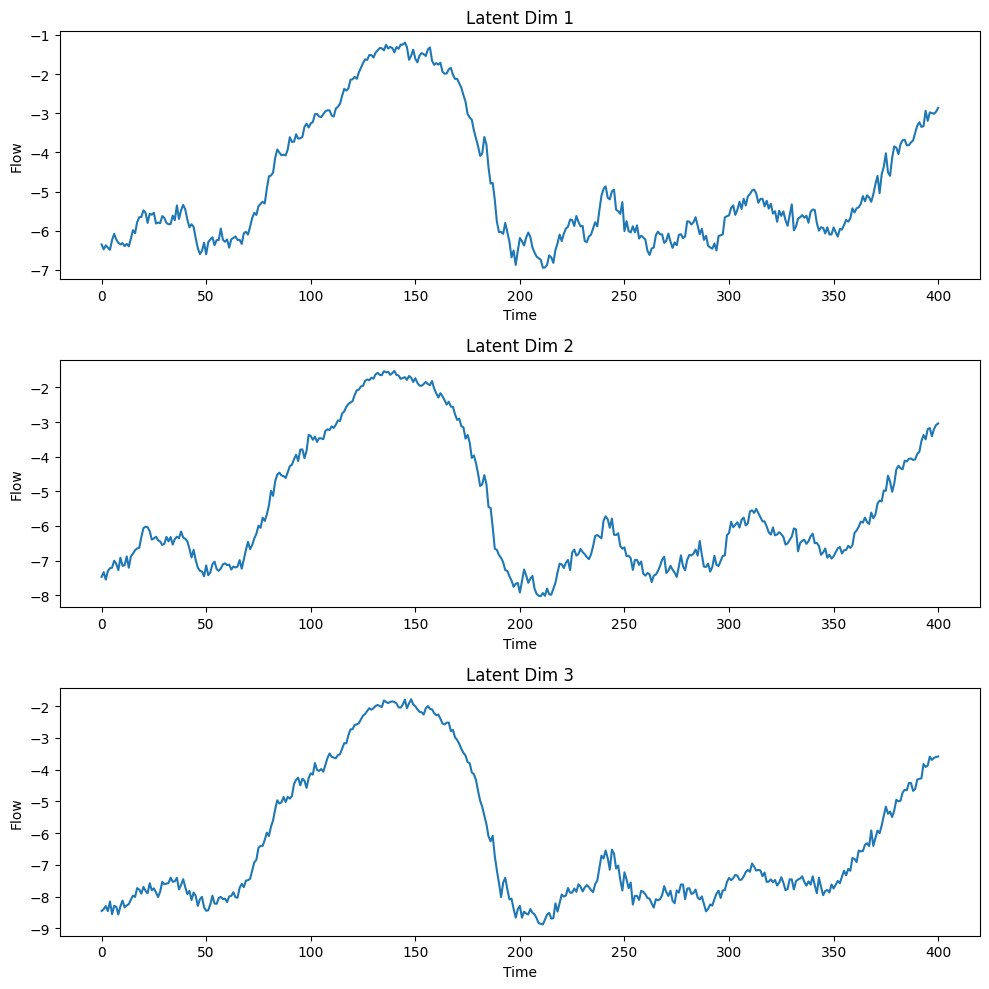

In [53]:
fig, axs = plt.subplots(nrows=params['latent_dim'] - params['partial_measurement'], ncols=1, figsize=(10, 10))

# Plot each column in a separate subplot
for i in range(params['partial_measurement'],z.shape[1]):
    #axs[i].plot(X_ori[:, i])
    axs[i-params['partial_measurement']].plot(z[:,i])

# Add titles and axis labels to the subplots
for i, ax in enumerate(axs):
    ax.set_title(f'Latent Dim {i+1}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Flow')

# Show the figure
plt.tight_layout()
plt.show()

In [54]:
dz_predict = results['dz_predict'].cpu().detach().numpy()
dz = results['dz'].cpu().detach().numpy()

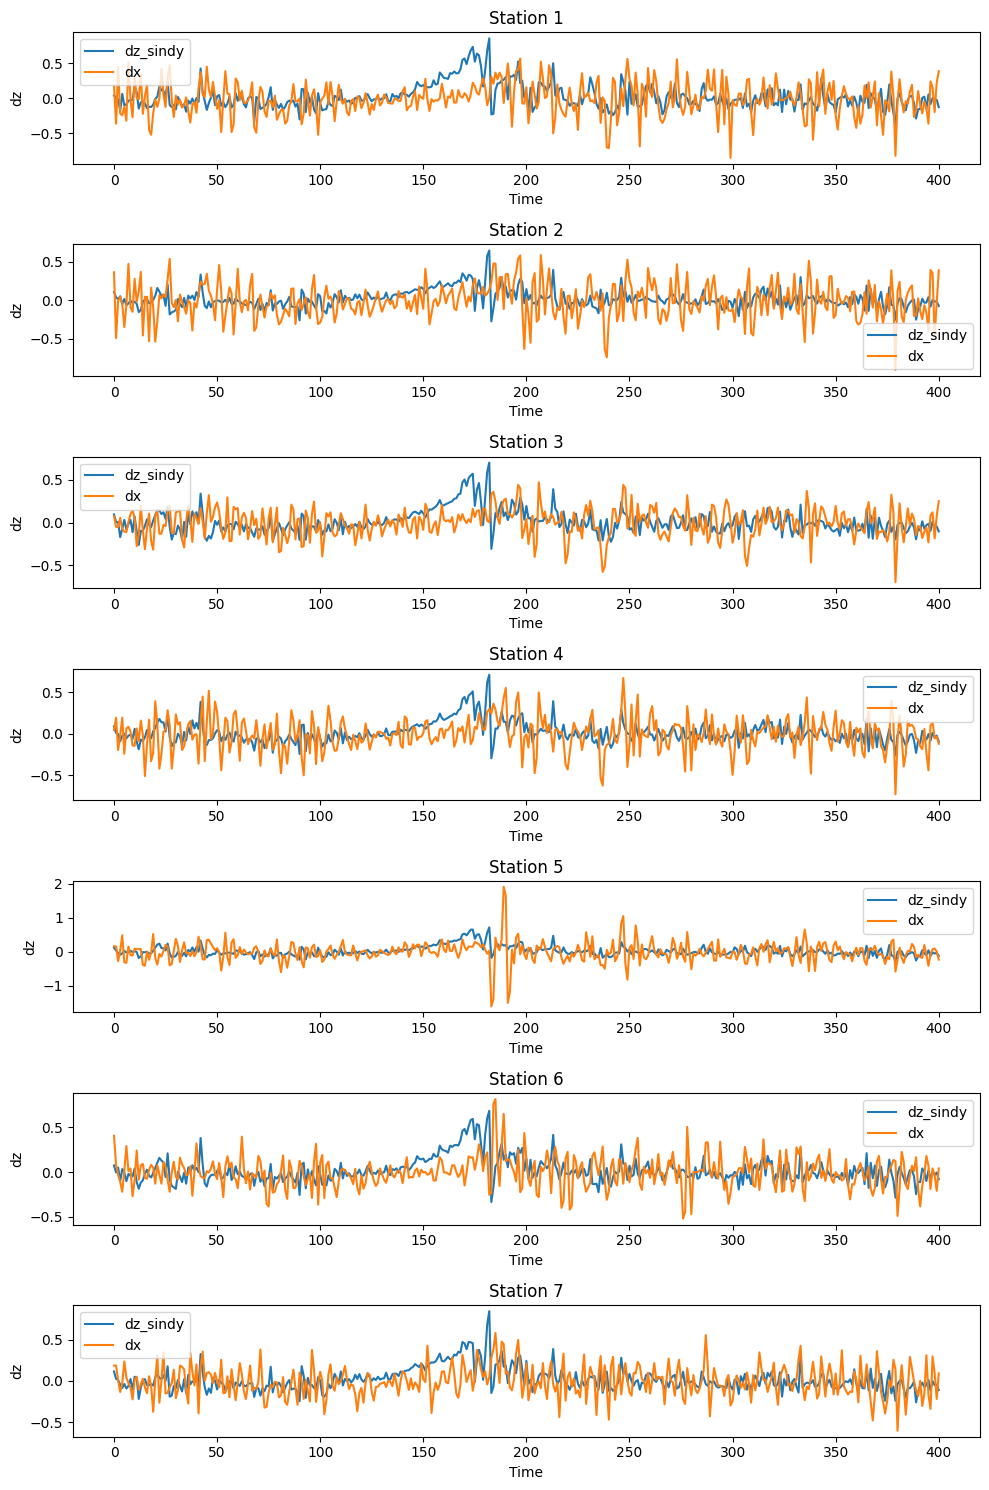

In [55]:
fig, axs = plt.subplots(nrows=dx_ori.shape[1], ncols=1, figsize=(10, 15))

# Plot each column in a separate subplot
for i in range(dx_ori.shape[1]):
    #axs[i].plot(dz[:, i], label = 'dz')
    axs[i].plot(dz_predict[:,i], label = 'dz_sindy')
    axs[i].plot(dx_ori[:,i], label = 'dx')
    axs[i].legend()

# Add titles and axis labels to the subplots
for i, ax in enumerate(axs):
    ax.set_title(f'Station {i+1}')
    ax.set_xlabel('Time')
    ax.set_ylabel('dz')

# Show the figure
plt.tight_layout()
plt.show()

In [72]:
#Simulate data with discovered governing equations
total_sim_timestep = 402
total_pred_step = 2
s = (total_sim_timestep+1, 10)
sim_result = np.zeros(s)
sim_result[0,:] = z[0,:].reshape(1,-1)

In [73]:
from sindy_utils import sindy_library

In [74]:
for t in range(0,total_sim_timestep,total_pred_step):
    z_init = z[t,:].reshape(1,-1)
    #sim_result[t,:] = z_init
    for s in range(total_pred_step):
        Theta_curr = sindy_library(z_init,2,False)
        dz_curr = np.matmul(Theta_curr,sindy_coeff)
        z_new = z_init + dz_curr
        sim_result[t+s+1,:] = z_new
        z_init = np.array(z_new)

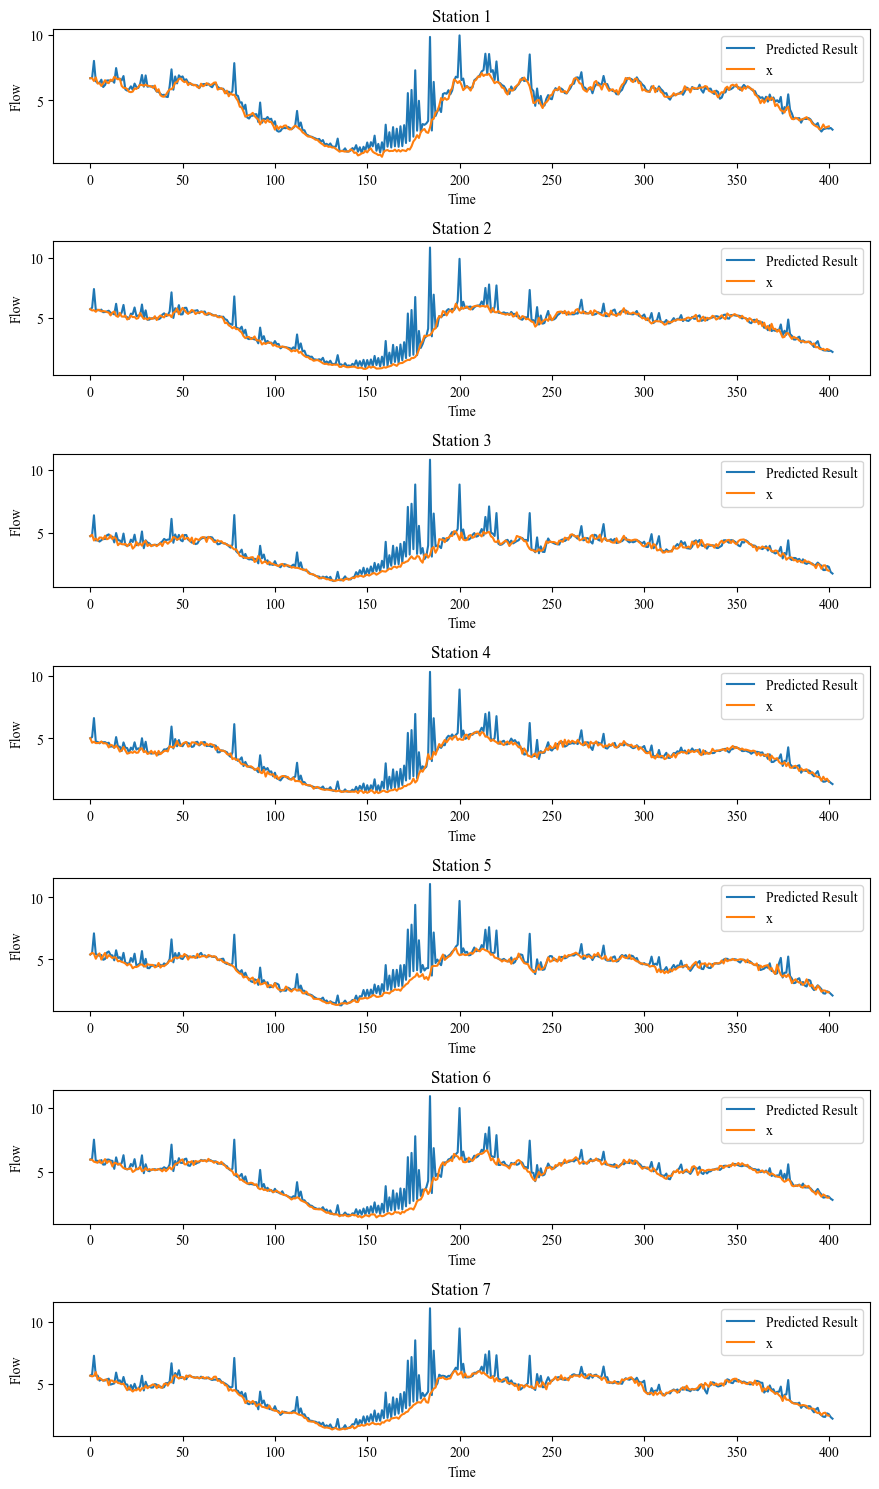

In [86]:
fig, axs = plt.subplots(nrows=X_ori.shape[1], ncols=1, figsize=(9, 15))

# Plot each column in a separate subplot
for i in range(X_ori.shape[1]):
    axs[i].plot(sim_result[:, i], label = 'Predicted Result')
    axs[i].plot(z[:,i], label = 'x')
    axs[i].legend()

# Add titles and axis labels to the subplots
for i, ax in enumerate(axs):
    ax.set_title(f'Station {i+1}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Flow')

# Show the figure
plt.tight_layout()
plt.show()

# Phase Plane

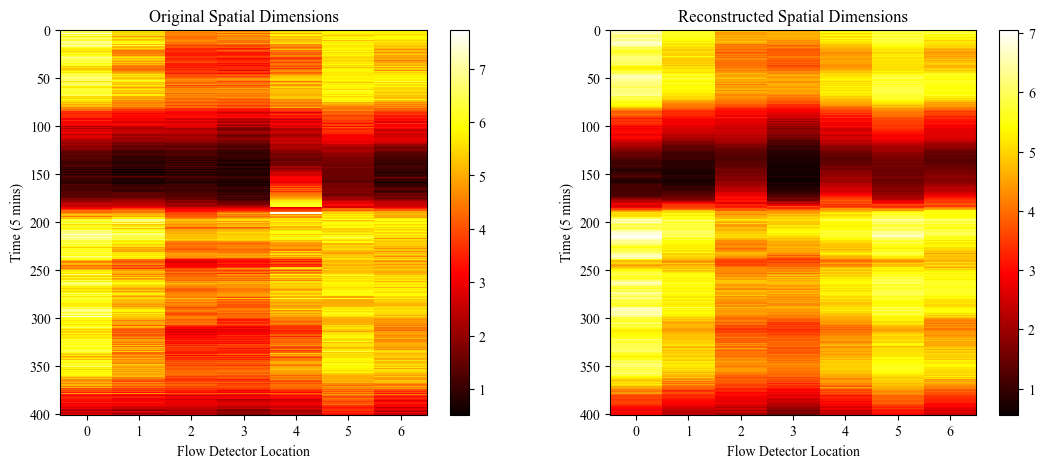

In [87]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
fig1 = axs[0].imshow(X_ori, cmap='hot', interpolation='nearest',aspect='auto')
plt.colorbar(fig1, ax = axs[0])
axs[0].set_xlabel('Flow Detector Location')
axs[0].set_ylabel('Time (5 mins)')
axs[0].set_title('Original Spatial Dimensions')

fig2 = axs[1].imshow(z[:,:params['partial_measurement']], cmap='hot', interpolation='nearest',aspect='auto')
plt.colorbar(fig2, ax = axs[1])
axs[1].set_xlabel('Flow Detector Location')
axs[1].set_ylabel('Time (5 mins)')
axs[1].set_title('Reconstructed Spatial Dimensions')
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()

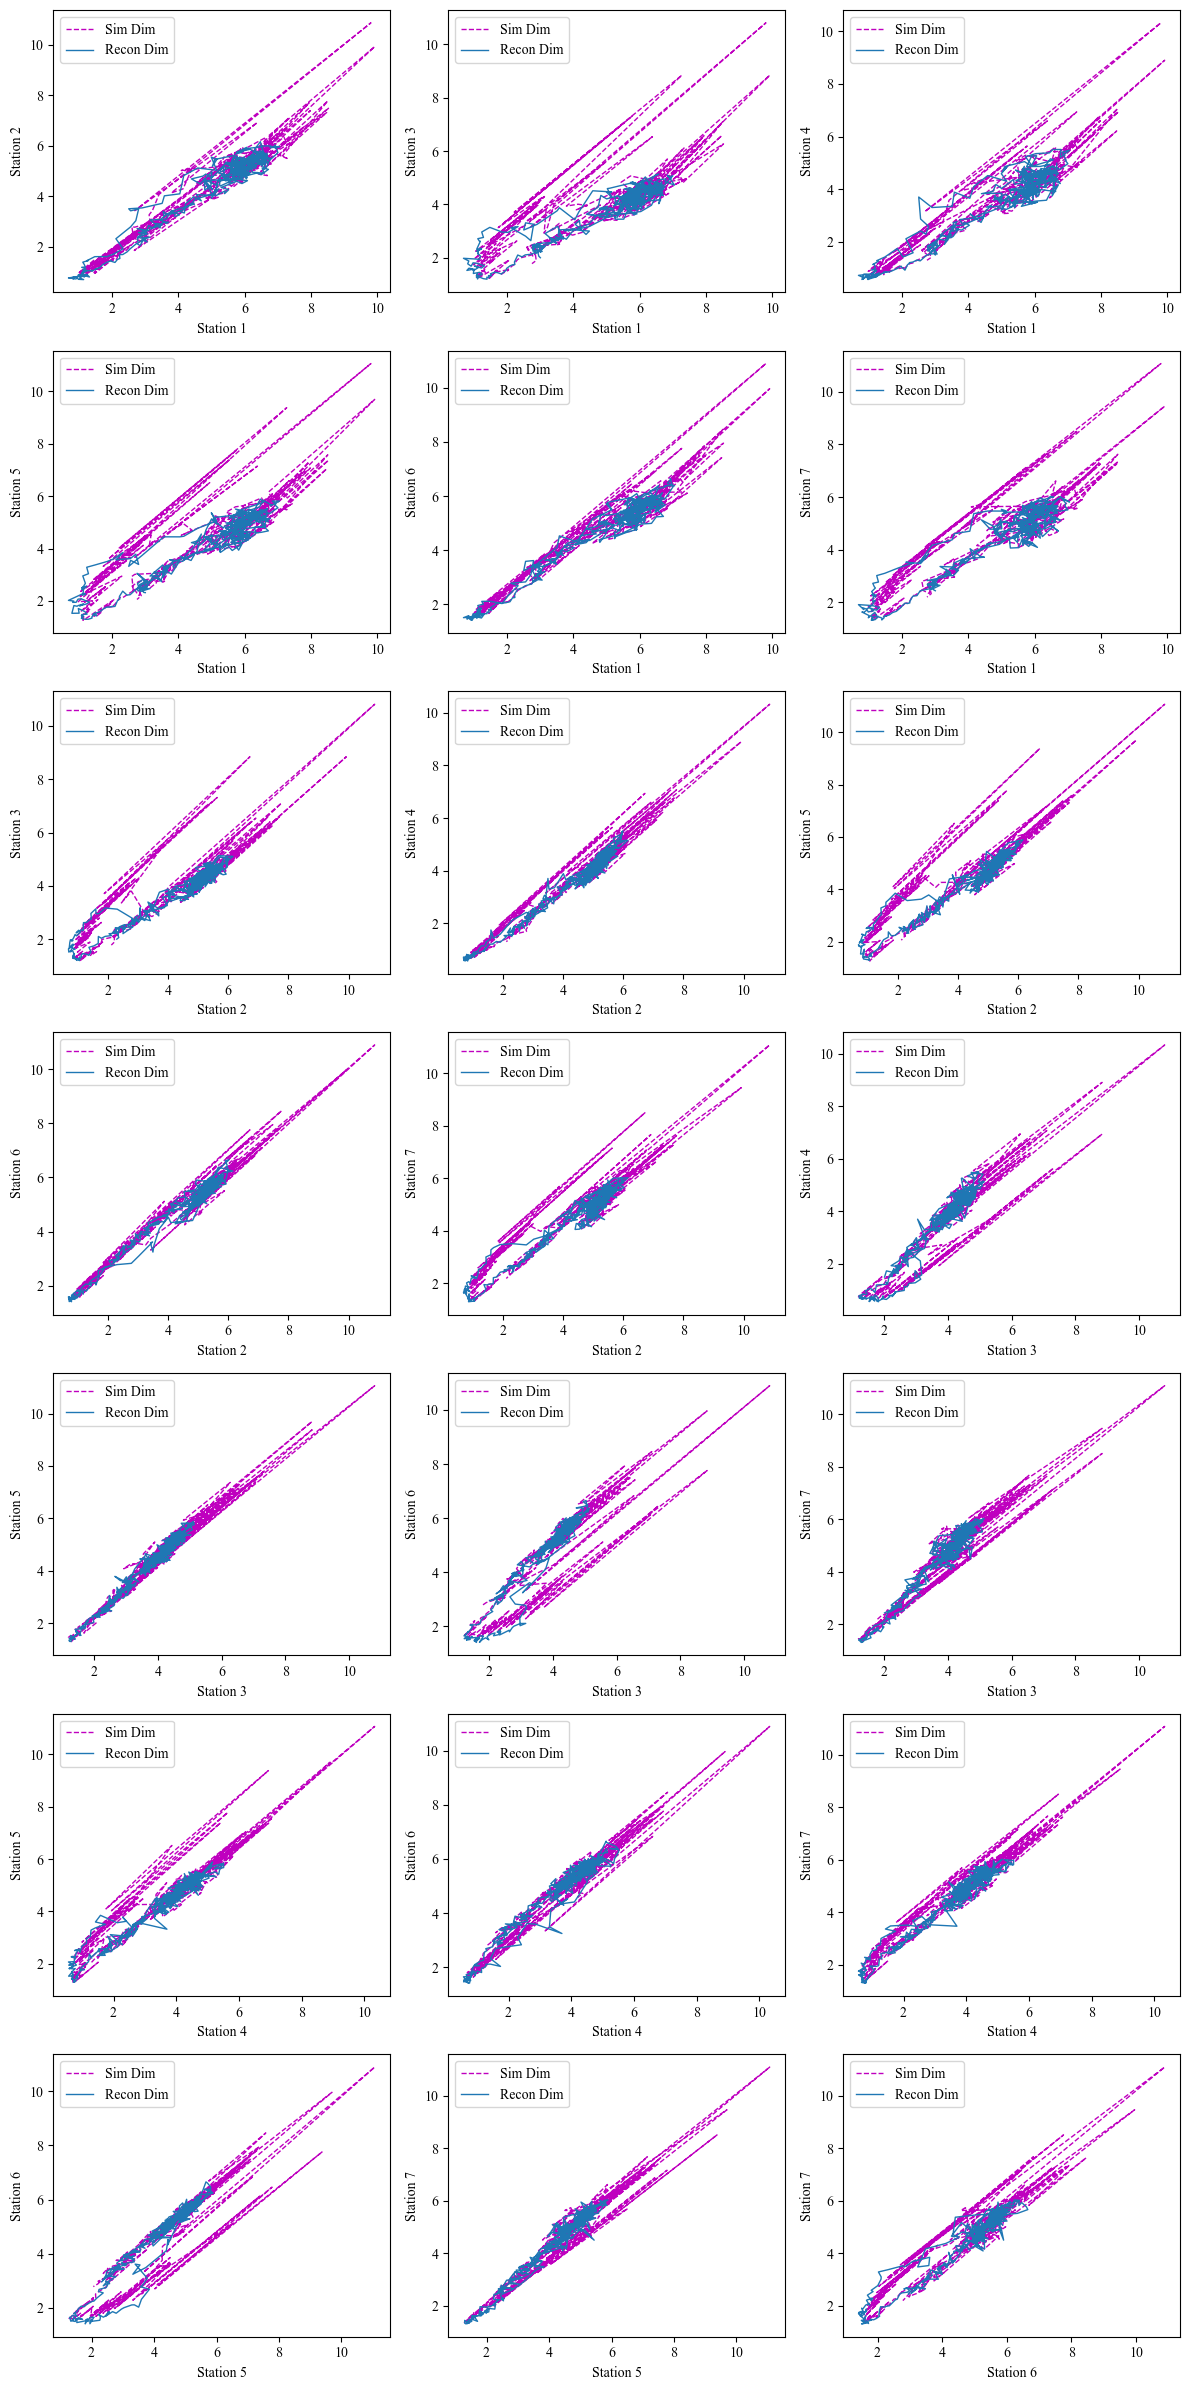

In [88]:
indices = range(7)
index_pair = []
for i in range(7):
    for j in range(i+1, 7):
        index_pair.append((indices[i], indices[j]))

fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(12, 24))
for row in range(7):
    for col in range(3):
        index1 = index_pair[row*3 + col][0]
        index2 = index_pair[row*3 + col][1]
        #axs[row, col].plot(X_ori[:,index1], X_ori[:,index2], linewidth = 1, label = 'Ori Dim')
        axs[row, col].plot(sim_result[:,index1], sim_result[:,index2], "--m",linewidth = 1, label = 'Sim Dim')
        axs[row, col].plot(z[:,index1], z[:,index2], linewidth = 1, label = 'Recon Dim')
        axs[row, col].legend()
        axs[row, col].set_xlabel(f'Station {index1 + 1}')
        axs[row, col].set_ylabel(f'Station {index2 + 1}')
plt.tight_layout()

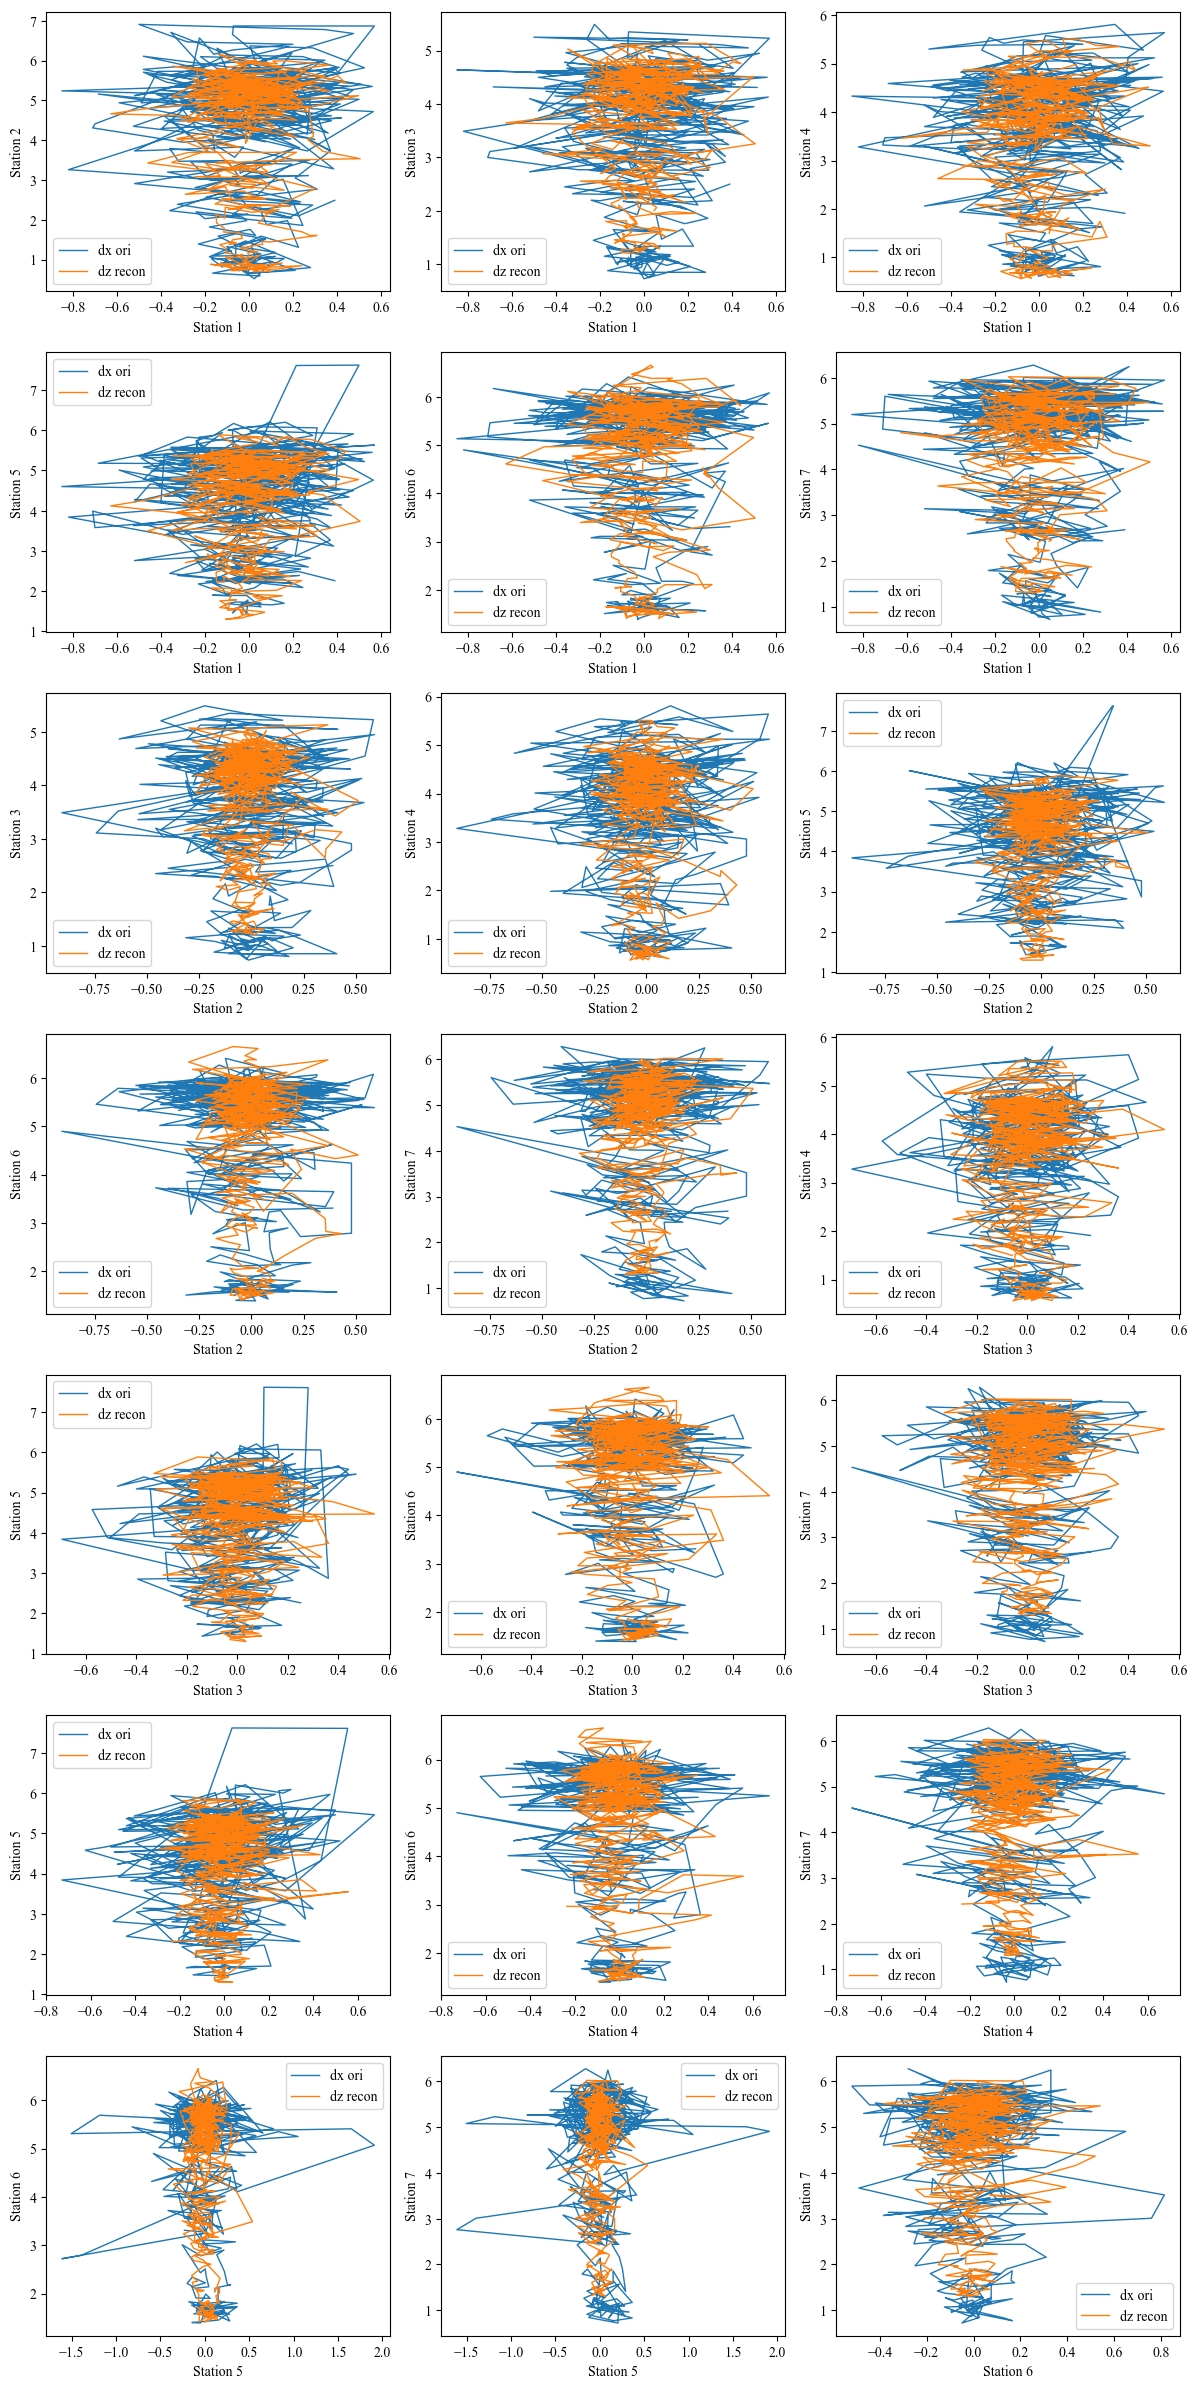

In [78]:
indices = range(7)
index_pair = []
for i in range(7):
    for j in range(i+1, 7):
        index_pair.append((indices[i], indices[j]))

fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(12, 24))
for row in range(7):
    for col in range(3):
        index1 = index_pair[row*3 + col][0]
        index2 = index_pair[row*3 + col][1]
        axs[row, col].plot(dx_ori[:,index1], X_ori[:,index2], linewidth = 1, label = 'dx ori')
        axs[row, col].plot(dz[:,index1], z[:,index2], linewidth = 1, label = 'dz recon')
        axs[row, col].legend()
        axs[row, col].set_xlabel(f'Station {index1 + 1}')
        axs[row, col].set_ylabel(f'Station {index2 + 1}')

plt.tight_layout()